In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from matplotlib.lines import Line2D
from scipy import stats
from input_str import tumor_solid_sample
from asso_analysis import STR_gene_cor, reg_out_cov


### STR-gene association analysis

In [144]:
cancer_type = "CRC"

## input STR data
pt_data, stn_data = tumor_solid_sample(cancer_type)
pt_data["allele_length"] = (pt_data["allele_a"] + pt_data["allele_b"])/2
pt_str = pt_data.pivot_table(index='tmp_id', columns='patient', values='allele_length')
pt_str = pt_str.loc[pt_str.isna().sum(axis = 1) < pt_str.shape[1]*0.9,]
pt_str = pt_str.loc[pt_str.std(axis = 1) > 0.1,]
pt_str.shape

In [147]:
# input gene expression data
gene_tumor = pd.read_csv("../gene_exp/" + cancer_type + "_tumor.tsv", index_col="gene_id", sep = "\t")
quantile_transformer = QuantileTransformer(random_state=42, output_distribution='normal')
trans_tumor_gene = pd.DataFrame(
            quantile_transformer.fit_transform(gene_tumor),
            index = gene_tumor.index,
            columns = gene_tumor.columns)
trans_tumor_gene = (trans_tumor_gene - trans_tumor_gene.mean())/trans_tumor_gene.std()

id_name = pd.read_csv("../gene_exp/gene_id_name.tsv", sep = "\t")
id_list = pd.DataFrame({"id" : trans_tumor_gene.index})
id_list = id_list.merge(id_name, left_on = "id", right_on = "gene_id", how = "left")
id_list.drop_duplicates(subset = "gene_name", inplace = True)
norm_tumor = trans_tumor_gene.loc[id_list["id"],]
norm_tumor.index = id_list["gene_name"]

str_gene = pd.read_csv("./output/STR_gene_pairs.tsv", sep = "\t")
pairs = pd.DataFrame({"tmp_id" : pt_str.index}).merge(str_gene, on = "tmp_id")
pairs = pairs.loc[pairs["gene_id"].isin(np.intersect1d(pairs["gene_id"].unique(), norm_tumor.index))]
pairs["gene_tmp"] = [i.replace("-", "_").replace(".", "_") for i in pairs["gene_id"]]
norm_tumor.index = [i.replace("-", "_").replace(".", "_") for i in norm_tumor.index]

# pca file from gene expression data as covariates
gene_cov = pd.read_csv("../PC_covs/" + cancer_type + "_cov.tsv", sep = "\t")
gene_cov.index = [i.replace(".", "-") for i in gene_cov.index]

In [151]:
# meta data and MSI phenotype
meta_file = pd.read_csv("../processed_data/meta/" + cancer_type + "_meta_no_ffpe.csv")
meta_file["patient"] = ["-".join(i.split("-")[:3]) for i in meta_file["name"]]
meta_file["sample_type"] = [i.split("-")[3][:-1] for i in meta_file["name"]]
pt_samples = meta_file.loc[meta_file["sample_type"] == "01",]
pt_samples = pt_samples.sort_values(by = "plate", ascending= False) \
                .drop_duplicates(subset = "patient", keep = "first")

msi_info = pd.read_csv("../clinical/" + cancer_type + "_msi.csv")
msi_info.loc[msi_info["msi_status"] == "msi-l", "msi_status"] = "mss"
msi_info = msi_info.merge(pt_samples[["patient", "year"]], on = "patient", how = "left")
msi_info = msi_info[["patient", "gender", "ad_race", "year", "msi_status"]]
msi_info.fillna("unknow", inplace=True)
msi_info["gender"] = msi_info["gender"].replace("'--", "unknow")

In [ ]:
df_res = STR_gene_cor(pairs,pt_str, norm_tumor, gene_cov, num_pc = 2)
df_res.to_csv("./output/crc_estr.csv", index = False)

### Regress out the covariates

In [115]:
estr = df_res.query(" adj_p < 0.05 ")
estr = reg_out_cov(estr, pt_str, norm_tumor, gene_cov, num_pc = 2)
estr.to_csv("./output/crc_estr.csv", index = False)

### MSI conditional analysis

In [13]:
crc_estr = pd.read_csv("./output/crc_estr.csv")

In [14]:

msi_coef = []
msi_pvalue = []
for _, gene_str in crc_estr.iterrows():
    gene_id = gene_str["gene"]
    str_id = gene_str["str_id"]
    gene_name = gene_id.replace("-", "_").replace(".", "_")
    
    one_str = pt_str.loc[str_id,].to_frame()
    one_gene = norm_tumor.loc[gene_name,].to_frame()  
    one_gene = norm_tumor.loc[gene_name,].to_frame()
    test_pair = pd.merge(one_str, one_gene, left_on = "patient", right_on = one_gene.index)
    test_pair.dropna(inplace=True)
    test_pair = test_pair.merge(gene_cov, left_on = "patient", right_on = gene_cov.index, how = "left")
    test_pair = test_pair.merge(msi_info, on = "patient")

    numeric_vars =[str_id] + list(gene_cov.columns.values[:2])
    formula = gene_name + ' ~ ' + ' + '.join(numeric_vars) + ' + C(msi_status) + C(gender) + C(ad_race) + C(year)'
    model = smf.ols(formula, data = test_pair)
    result = model.fit()
    msi_coef.append(result.params[str_id])
    msi_pvalue.append(result.pvalues[str_id])
crc_estr["msi_coef"] = msi_coef
crc_estr["msi_pvalue"] = msi_pvalue
crc_estr["msi_adjp"] = multitest.multipletests(crc_estr["msi_pvalue"], method = "fdr_bh")[1]

In [ ]:
crc_estr.to_csv("./output/crc_estr.csv", index = False)

### eSTR plots

In [164]:
str_id = "chr4_82864412" 
gene_name = "SEC31A" 
one_str = pt_str.loc[str_id,].to_frame()
one_gene = norm_tumor.loc[gene_name,].to_frame()
test_pair = pd.merge(one_str, one_gene, left_on = "patient", right_on = one_gene.index)
test_pair.dropna(inplace=True)
test_pair = test_pair.merge(msi_info, on = "patient")
test_pair = test_pair.merge(gene_cov, left_on = "patient", right_on = gene_cov.index, how = "left")

Text(0.5, 1.0, 'SEC31A')

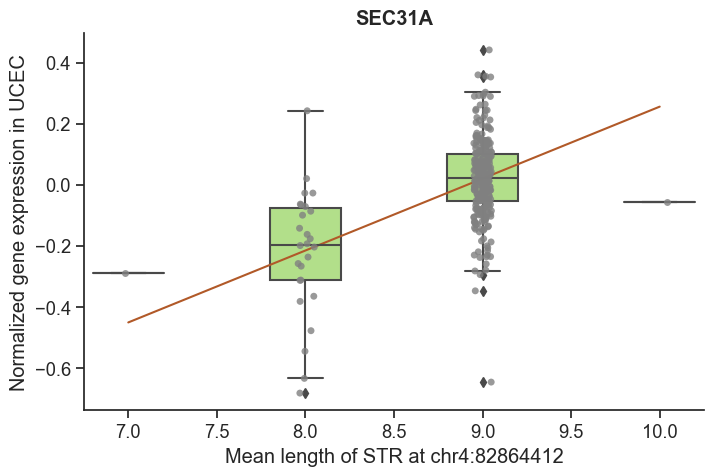

In [165]:
fill_gap = np.setdiff1d(np.arange(test_pair[str_id].min(), test_pair[str_id].max(), 0.5), test_pair[str_id].unique())

filled_data = pd.concat([test_pair[[str_id, "reg_gene", "msi_status"]], 
           pd.DataFrame({str_id: fill_gap, "reg_gene" : [np.nan]*len(fill_gap)})])

coef, inter = crc_estr.loc[(crc_estr["str_id"] == str_id) & (crc_estr["gene"] == gene_name) , ["resid_coef", "resid_inter"]].values[0]
x1 = 0
x2 = (test_pair[str_id].max() - test_pair[str_id].min())*2
y1 = test_pair[str_id].min()*coef + inter
y2 = test_pair[str_id].max()*coef + inter

fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi = 100)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style = "ticks", rc = custom_params, font_scale = 1.2)

sns.boxplot(ax = axes, data = filled_data, x = str_id, y = "reg_gene",
            boxprops={'facecolor':sns.color_palette("Paired")[2]})
sns.stripplot(data = filled_data, x = str_id, y = "reg_gene",
             ax = axes, color = "grey", alpha = 0.8)

axes.plot([x1, x2], [y1,y2], color = sns.color_palette("Paired")[-1])
axes.set_xlabel("Mean length of STR at " + str_id.replace("_", ":"))
axes.set_ylabel("Normalized gene expression in UCEC")
axes.set_title(gene_name, weight = "bold")

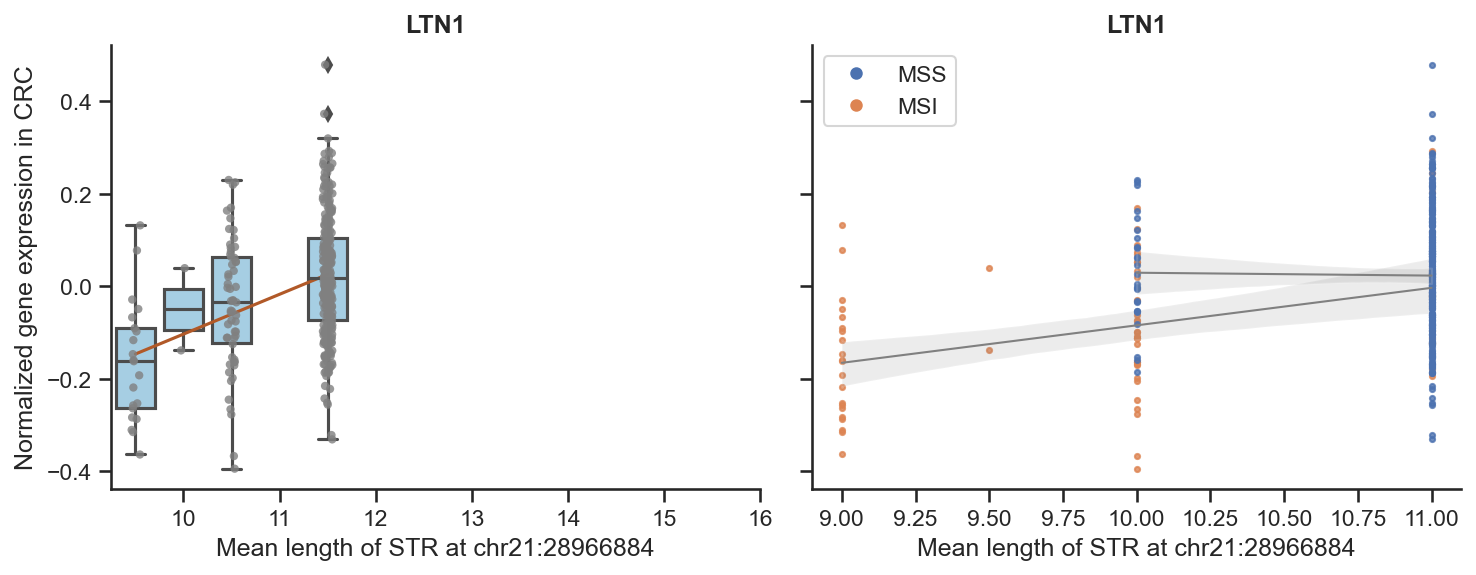

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi = 150, sharey=True)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.0)

sns.boxplot(ax = axes[0], data = filled_data, x = str_id, y = "reg_gene",
            boxprops={'facecolor':sns.color_palette("Paired")[0]})
sns.stripplot(data = filled_data, x = str_id, y = "reg_gene",
             ax = axes[0], color = "grey", alpha = 0.8, s= 4)

axes[0].plot([x1, x2], [y1,y2], color = sns.color_palette("Paired")[-1])
axes[0].set_xlabel("Mean length of STR at " + str_id.replace("_", ":"))
axes[0].set_ylabel("Normalized gene expression in CRC")
axes[0].set_title(gene_name, weight = "bold")
axes[0].set_xticks(range(1,15,2)) 
axes[0].set_xticklabels([10,11,12,13,14,15,16])

sns.regplot(ax = axes[1], 
            data = test_pair.query(" msi_status == 'msi-h' "), 
            x = str_id, 
            y = "reg_gene", 
            scatter_kws={'s':6}, 
            line_kws={"color": "gray", "linewidth" : 1}, 
            color = sns.color_palette("deep")[1])
sns.regplot(ax = axes[1], 
            data = test_pair.query(" msi_status == 'mss' "), 
            x = str_id, 
            y = "reg_gene", 
            scatter_kws={'s':6}, 
            line_kws={"color": "gray", "linewidth" : 1}, 
            color = sns.color_palette("deep")[0])
axes[1].set_xlabel("Mean length of STR at " + str_id.replace("_", ":"))
axes[1].set_ylabel("")
axes[1].set_title(gene_name, weight = "bold")

mss_circle = Line2D([], [], marker='.', color = sns.color_palette("deep")[0],
                    label='MSS', linestyle='None',
                     markersize = 10)
msi_circle = Line2D([], [], marker='.', color = sns.color_palette("deep")[1],
                    label='MSI', linestyle='None',
                     markersize = 10)
plt.legend(handles = [mss_circle, msi_circle],
            loc='upper left')
fig.tight_layout()